In [68]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

shared_datadir = Path(r"D:\OneDrive\programs\anipaint\anipaint\tests\data")
tmp_path = Path(r"m:/deldir/anipaint/tests")

logging.basicConfig(level=logging.INFO)
plt.rcParams['figure.figsize'] = [12, 8]

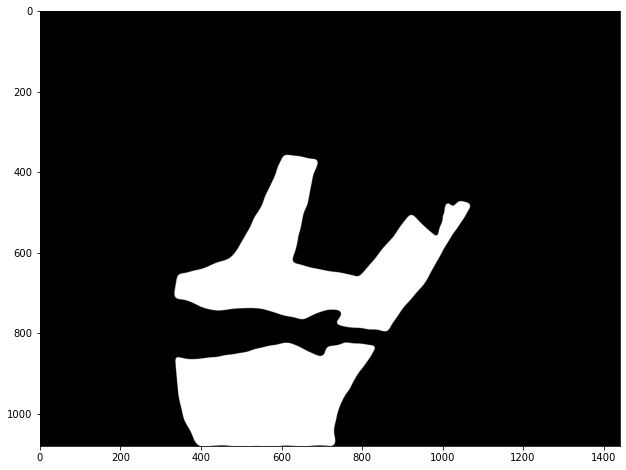

In [69]:
# open a matte
matte_file = "Comp 2/ShirtMAtte_00000.jpg"

matte_path = shared_datadir / matte_file

matte_image = Image.open(matte_path)
plt.imshow(matte_image)
plt.show()

In [11]:
assert matte_image.mode == "RGB", f"Expect images to be RGB, not {matte_image.mode}"
rgb_array = np.array(matte_image)
print(np.unique(rgb_array.mean(axis=2), return_counts=True))

(array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 1

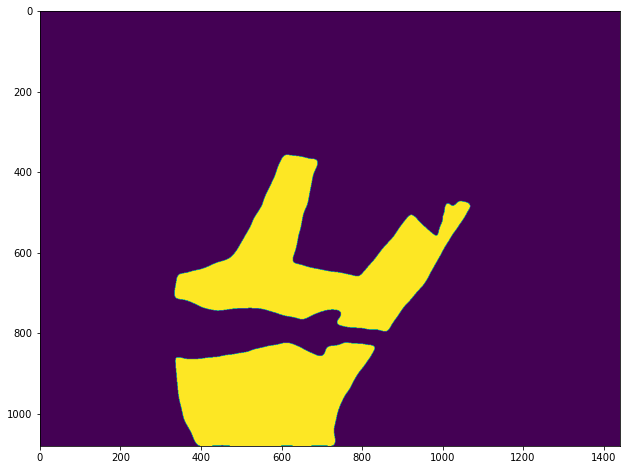

[  0 255]
35.88036265432099
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [70]:
threshold = 127
gray_array = np.where(rgb_array.mean(axis=2)<threshold,0,255)
plt.imshow(gray_array)
plt.show()
print(np.unique(gray_array))
print(gray_array.mean())
print(gray_array)

In [19]:
# References:
#  https://stackoverflow.com/questions/48585468/vectorize-conways-game-of-life-in-pure-numpy
#  Search this more: cellular automata numpy
#  Also look at image kernels and implementing guassian, etc blur
#  Also look for libraries
#  https://datacarpentry.org/image-processing/08-edge-detection/
#  https://jessicastringham.net/2017/12/31/stride-tricks/ -- Implementing convolutions with stride_tricks
#  https://setosa.io/ev/image-kernels/


In [20]:
from numpy.lib.stride_tricks import as_strided

# See http://drsfenner.org/blog/2015/08/game-of-life-in-numpy-2/
def grid_nD(arr):
    assert all(_len>2 for _len in arr.shape)
    
    nDims = len(arr.shape)
    newShape = [_len-2 for _len in arr.shape]
    newShape.extend([3] * nDims)
    
    newStrides = arr.strides + arr.strides
    return as_strided(arr, shape=newShape, strides=newStrides)

In [33]:
expanded = grid_nD(gray_array)
expanded[0,0]

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [63]:
for i in range(230):
    middle = expanded[:,:,1,1]
    #print(middle.shape)
    minplus1 = np.min(expanded,axis=(-2,-1))+1
    #print(minplus1.shape)
    next = np.minimum(middle,minplus1)
    expanded[:,:,1,1] = next
print(np.unique(next))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113]


In [53]:
expanded[:,:,1,1] = next

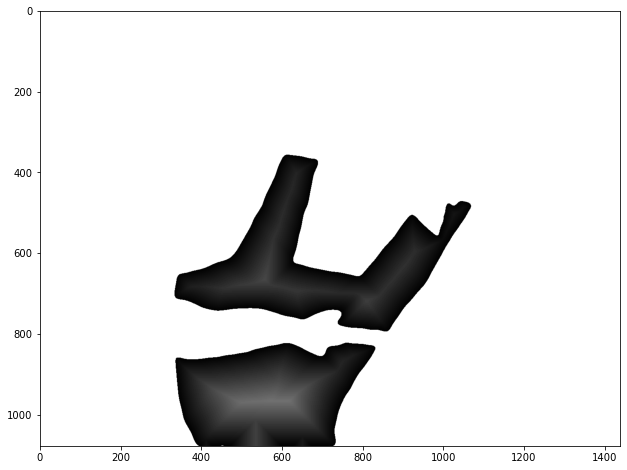

In [71]:
plt.imshow(np.where(middle==0,256,middle),cmap='gray', vmin=0, vmax=255)
plt.show()